In [1]:
import pickle
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import os

C:\Users\mrmrk\AppData\Local\Temp\ipykernel_24536\4014843290.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:



with open('wdbc.pkl', 'rb') as f:
    data = pickle.load(f)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(data)

           id  malignant  radius_0  texture_0  perimeter_0  area_0  \
0      842302          1     17.99      10.38       122.80  1001.0   
1      842517          1     20.57      17.77       132.90  1326.0   
2    84300903          1     19.69      21.25       130.00  1203.0   
3    84348301          1     11.42      20.38        77.58   386.1   
4    84358402          1     20.29      14.34       135.10  1297.0   
..        ...        ...       ...        ...          ...     ...   
564    926424          1     21.56      22.39       142.00  1479.0   
565    926682          1     20.13      28.25       131.20  1261.0   
566    926954          1     16.60      28.08       108.30   858.1   
567    927241          1     20.60      29.33       140.10  1265.0   
568     92751          0      7.76      24.54        47.92   181.0   

     smoothness_0  compactness_0  concavity_0  concave points_0  ...  \
0         0.11840        0.27760      0.30010           0.14710  ...   
1         0.084

In [5]:
data.columns

Index(['id', 'malignant', 'radius_0', 'texture_0', 'perimeter_0', 'area_0',
       'smoothness_0', 'compactness_0', 'concavity_0', 'concave points_0',
       'symmetry_0', 'fractal dimension_0', 'radius_1', 'texture_1',
       'perimeter_1', 'area_1', 'smoothness_1', 'compactness_1', 'concavity_1',
       'concave points_1', 'symmetry_1', 'fractal dimension_1', 'radius_2',
       'texture_2', 'perimeter_2', 'area_2', 'smoothness_2', 'compactness_2',
       'concavity_2', 'concave points_2', 'symmetry_2', 'fractal dimension_2'],
      dtype='object')

In [6]:
data[['malignant', 'radius_0']]

,malignant,radius_0
0,1,17.99
1,1,20.57
2,1,19.69
3,1,11.42
4,1,20.29
...,...,...
564,1,21.56
565,1,20.13
566,1,16.60
567,1,20.60


In [7]:

X = data.drop(["malignant", "id"], axis=1)
Y = data['malignant']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [8]:
X_data_tensor = (torch.tensor(data[["radius_0", "symmetry_1", "smoothness_1", "radius_1"]].values)).float()
Y_data_tensor = (torch.tensor(Y.values)).float()
X_train_tensor = (torch.tensor(X_train[["radius_0", "symmetry_1", "smoothness_1", "radius_1"]].values)).float()
y_train_tensor = (torch.tensor(y_train.values)).float()
X_test_tensor = (torch.tensor(X_test[["radius_0", "symmetry_1", "smoothness_1", "radius_1"]].values)).float()
y_test_tensor = (torch.tensor(y_test.values)).float()

In [9]:
features = ["radius_0", "symmetry_1", "smoothness_1", "radius_1"]
means = torch.mean(X_data_tensor, dim = 0).to(device)
intervals = torch.max(X_data_tensor, dim = 0).values.to(device) - torch.min(X_data_tensor, dim = 0).values.to(device)

print(means)
print(intervals)


tensor([1.4127e+01, 2.0542e-02, 7.0410e-03, 4.0517e-01], device='cuda:0')
tensor([21.1290,  0.0711,  0.0294,  2.7615], device='cuda:0')


In [10]:
def grade_args(thresholds, comps, x, y):
    expanded_a = thresholds.unsqueeze(1).to(device)
    expanded_b = x.unsqueeze(0).to(device)
    result = (expanded_b >= expanded_a).permute(1, 0, 2).to(device)  
    # Convert comps to boolean tensor
    comps_bool = comps.bool().to(device)
    flipped = (result ^ comps_bool).to(device)
    flipped_back = flipped.permute(1, 0, 2).to(device)
    sumed = flipped_back.any(dim=2).to(device)
    mask = (sumed == y.reshape(1, -1).to(device)).to(device)
    
    return (torch.sum(mask, dim=1) / mask.shape[1]).to(device)


In [11]:


nr_of_searches = 100000
epochs = 3000
best_one = None
if not os.path.exists('brute.pth'):
    for _ in tqdm(range(epochs)):
        threasholds =  torch.rand((nr_of_searches, len(features))).to(device)
        threasholds = threasholds * intervals
        threasholds = threasholds + means
        comps =  torch.randint(0, 2, (nr_of_searches, len(features))).to(device)
        grades = grade_args(threasholds, comps, X_train_tensor, y_train_tensor)
        best_index = torch.argmax(grades)
        best_gard = grades[best_index]
        best_threasholds = threasholds[best_index]
        best_comps = comps[best_index]
        if best_one == None or best_one[0].item() < best_gard.item():
            best_one = (best_gard, best_threasholds, best_comps)
   
    torch.save(best_one, 'brute.pth')

In [12]:
def safe_grade(threasholds, comps_values, x, y):
    y = y.to(device)
    comps = []
    for c in comps_values:
        if c == 0:
            comp = lambda x, t: x >= t
        else:
            comp = lambda x, t: x < t
        comps.append(comp)
    masks = []
    for i in range(len(comps)):
        masks.append(comps[i](x[:,i].to(device), threasholds[i]))
    mask = torch.stack(masks, dim = 1)
    sumed = mask.any(dim = 1).to(device)
    return torch.sum(sumed == y) / y.shape[0]
        
        
            

In [13]:

score, best_threasholds, best_comps = torch.load('brute.pth')
print(score.item())
print(safe_grade(best_threasholds, best_comps, X_test_tensor, y_test_tensor).item())
grade_args(best_threasholds.unsqueeze(0), best_comps.unsqueeze(0), X_test_tensor, y_test_tensor).item()


0.9076923727989197
0.8684210777282715


0.8684210777282715

In [14]:

def find_threashold2( name, n):
    results = []
    radius = data[name]
    for x in np.linspace(np.min(radius), np.max(radius), n):#range(int(np.min(radius)),int(np.max(radius)), step):
        mask1 = radius > x
        mask2 = radius <= x

        group1 = data['malignant'][mask1]
        group2 = data['malignant'][mask2]


        if np.sum(group1) > np.sum(group2):
            
            results.append((x, np.sum(group1) +   group2.shape[0] - np.sum(group2), ">"))
        else:
            results.append((x, group1.shape[0]-np.sum(group1) +   np.sum(group2), "<"))
    print(results)
    return max(results, key=lambda x: x[1])

     
find_threashold2( "radius_0", 1000)

[(6.981, 213, '>'), (7.00215015015015, 213, '>'), (7.0233003003003, 213, '>'), (7.044450450450451, 213, '>'), (7.0656006006006, 213, '>'), (7.086750750750751, 213, '>'), (7.1079009009009, 213, '>'), (7.129051051051051, 213, '>'), (7.150201201201201, 213, '>'), (7.171351351351351, 213, '>'), (7.192501501501502, 213, '>'), (7.213651651651651, 213, '>'), (7.234801801801802, 213, '>'), (7.2559519519519515, 213, '>'), (7.277102102102102, 213, '>'), (7.298252252252252, 213, '>'), (7.319402402402402, 213, '>'), (7.340552552552553, 213, '>'), (7.361702702702702, 213, '>'), (7.382852852852853, 213, '>'), (7.404003003003003, 213, '>'), (7.425153153153153, 213, '>'), (7.446303303303303, 213, '>'), (7.467453453453453, 213, '>'), (7.488603603603604, 213, '>'), (7.5097537537537535, 213, '>'), (7.530903903903904, 213, '>'), (7.552054054054054, 213, '>'), (7.573204204204204, 213, '>'), (7.594354354354354, 213, '>'), (7.6155045045045044, 213, '>'), (7.636654654654654, 213, '>'), (7.657804804804805, 213

(15.018057057057057, 506, '>')

In [15]:

def find_threashold( name, step):
    results1 = []
    radius = data[name]
    for x in np.linspace(np.min(radius), np.max(radius), int(len(radius)/step)):#range(int(np.min(radius)),int(np.max(radius)), step):
        sick_mask = radius > x
        healthy_max = radius <= x

        sicks = data['malignant'][sick_mask]
        heaths = data['malignant'][healthy_max]

        score = sicks.shape[0]-np.sum(sicks) +   np.sum(heaths)
        results1.append((x, score))
    min1 = min(results1, key=lambda x: x[1])
    results2 = []
    for x in np.linspace(np.min(radius), np.max(radius), int(len(radius)/step)):#range(int(np.min(radius)),int(np.max(radius)), step):
        sick_mask = radius < x
        healthy_max = radius >= x

        sicks = data['malignant'][sick_mask]
        heaths = data['malignant'][healthy_max]

        score = sicks.shape[0]-np.sum(sicks) +  np.sum(heaths)
        results2.append((x, score))
    min2 = min(results2, key=lambda x: x[1])

    print(results1)
    print(results2)
    if min1[1] < min2[1]:
        return min1[0], ">"
    else:
        return min2[0], "<"

     
find_threashold( "radius_0", 0.1)

[(6.981, 356), (6.984714009492002, 356), (6.9884280189840045, 356), (6.992142028476006, 356), (6.995856037968008, 356), (6.99957004746001, 356), (7.003284056952013, 356), (7.006998066444015, 356), (7.010712075936016, 356), (7.014426085428019, 356), (7.018140094920021, 356), (7.021854104412023, 356), (7.025568113904026, 356), (7.029282123396027, 356), (7.032996132888029, 356), (7.036710142380032, 356), (7.040424151872034, 356), (7.044138161364036, 356), (7.0478521708560375, 356), (7.05156618034804, 356), (7.055280189840042, 356), (7.058994199332044, 356), (7.062708208824047, 356), (7.066422218316048, 356), (7.07013622780805, 356), (7.073850237300053, 356), (7.077564246792055, 356), (7.081278256284056, 356), (7.084992265776059, 356), (7.088706275268061, 356), (7.092420284760063, 356), (7.0961342942520655, 356), (7.099848303744067, 356), (7.103562313236069, 356), (7.1072763227280715, 356), (7.110990332220074, 356), (7.114704341712076, 356), (7.1184183512040775, 356), (7.12213236069608, 35

(15.040400597644577, '>')

In [16]:
threashold = {name: find_threashold2(name, 1000) for name in ["radius_0", "symmetry_1", "smoothness_1", "radius_1"]}

threashold

[(6.981, 213, '>'), (7.00215015015015, 213, '>'), (7.0233003003003, 213, '>'), (7.044450450450451, 213, '>'), (7.0656006006006, 213, '>'), (7.086750750750751, 213, '>'), (7.1079009009009, 213, '>'), (7.129051051051051, 213, '>'), (7.150201201201201, 213, '>'), (7.171351351351351, 213, '>'), (7.192501501501502, 213, '>'), (7.213651651651651, 213, '>'), (7.234801801801802, 213, '>'), (7.2559519519519515, 213, '>'), (7.277102102102102, 213, '>'), (7.298252252252252, 213, '>'), (7.319402402402402, 213, '>'), (7.340552552552553, 213, '>'), (7.361702702702702, 213, '>'), (7.382852852852853, 213, '>'), (7.404003003003003, 213, '>'), (7.425153153153153, 213, '>'), (7.446303303303303, 213, '>'), (7.467453453453453, 213, '>'), (7.488603603603604, 213, '>'), (7.5097537537537535, 213, '>'), (7.530903903903904, 213, '>'), (7.552054054054054, 213, '>'), (7.573204204204204, 213, '>'), (7.594354354354354, 213, '>'), (7.6155045045045044, 213, '>'), (7.636654654654654, 213, '>'), (7.657804804804805, 213

{'radius_0': (15.018057057057057, 506, '>'),
 'symmetry_1': (0.017770340340340342, 325, '<'),
 'smoothness_1': (0.006483324324324325, 302, '<'),
 'radius_1': (0.41280480480480486, 469, '>')}

In [17]:

def predict(threasholds,person):
    for key in threasholds.keys():
        if threasholds[key][1] == ">":
            if threasholds[key][0] > person[key]:
                return True
        else:
            if threasholds[key][0] < person[key]:
                return True
    return False

right = 0
for i in range(data.shape[0]):
    person = data.iloc[i]

    if (predict(threashold, person)) == bool(person["malignant"]):
        right += 1
acc = right / data.shape[0]
acc


0.5219683655536028

In [18]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

mask_benign = y_test == 0
mask_malignant = y_test == 1

print(np.sum(clf.predict(X_test) == y_test) / len(y_test))
print(np.sum(clf.predict(X_test[mask_benign]) == y_test[mask_benign]) / len(y_test[mask_benign]))
print(np.sum(clf.predict(X_test[mask_malignant]) == y_test[mask_malignant]) / len(y_test[mask_malignant]))

0.9473684210526315
1.0
0.8571428571428571


In [19]:

X_train_tensor = (torch.tensor(X_train.values)).float()
y_train_tensor = (torch.tensor(y_train.values)).float()
X_test_tensor = (torch.tensor(X_test.values)).float()
y_test_tensor = (torch.tensor(y_test.values)).float()
print(X_train_tensor.shape)
# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        out = self.linear(x)
        out2 = nn.ReLU()(out)
        return (out)

# Define the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]  # Number of features
output_dim = 1  # Number of outputs (in this case, single value)
model = LinearRegression(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.002)  # Stochastic Gradient Descent optimizer

# Train the model
num_epochs = 30000
train_loss = []
val_loss = []
val_interval = 100
if not os.path.exists('linear.pth'):
    for epoch in tqdm(range(num_epochs)):
        # Backward pass and optimization

        # Forward pass
        outputs = model(X_train_tensor).squeeze(1)
        loss = criterion((outputs), y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
        if (epoch+1) % val_interval == 0:
            with torch.no_grad():
                outputs = model(X_test_tensor).squeeze(1)
                loss = criterion((outputs), y_test_tensor)
                val_loss.append(loss.item())
    torch.save({"model": model.state_dict(), "train_loss": train_loss, "val_loss": val_loss}, 'linear.pth')

torch.Size([455, 30])


In [20]:
d = torch.load('linear.pth')
model.load_state_dict(d["model"])
train_loss = d["train_loss"]
val_loss = d["val_loss"]

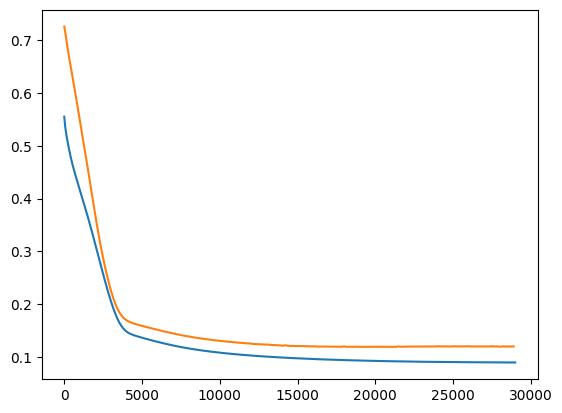

In [21]:
skip = 1000
plt.plot(train_loss[skip:])
plt.plot((range(0,len(val_loss)*val_interval - skip, val_interval)), val_loss[skip // val_interval:])

In [22]:
# Test the trained model
with torch.no_grad():
    predicted = model(X_train_tensor).detach().squeeze(1) > 0.5
    
    print(predicted.shape, y_train_tensor.shape)
    print("Predicted train values:", torch.sum(predicted == y_train_tensor) / y_train_tensor.shape[0])
    predicted = model(X_test_tensor).detach().squeeze(1) > 0.5
    print("Predicted test values:", torch.sum(predicted == y_test_tensor) / y_test_tensor.shape[0])


torch.Size([455]) torch.Size([455])
Predicted train values: tensor(0.9604)
Predicted test values: tensor(0.9298)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=92c239af-b063-49da-a4b6-10d69960a407' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>